In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.dates as mdates

/tmp/ipykernel_7313/727316262.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
ds = np.load("dataset_full.npy", allow_pickle=True)

In [4]:
print(ds.shape)
ds.item().get("72492570")

()


{'Glucose': [157,
  154,
  153,
  151,
  148,
  148,
  157,
  157,
  156,
  127,
  123,
  120,
  116,
  114,
  111,
  110,
  104,
  103,
  101,
  99,
  97,
  93,
  91,
  91,
  89,
  88,
  91,
  93,
  92,
  90,
  88,
  91,
  90,
  88,
  88,
  88,
  88,
  88,
  85,
  89,
  91,
  91,
  91,
  92,
  92,
  118,
  127,
  131,
  129,
  127,
  127,
  133,
  135,
  138,
  137,
  130,
  129,
  136,
  138,
  140,
  142,
  142,
  140,
  140,
  142,
  145,
  155,
  133,
  121,
  118,
  126,
  196,
  185,
  173,
  161,
  149,
  135,
  131,
  95,
  94,
  84,
  85,
  92,
  104,
  97,
  111,
  140,
  146,
  136,
  141,
  142,
  139,
  136,
  137,
  130,
  122,
  132,
  128,
  123,
  125,
  124,
  127,
  131,
  137,
  124,
  128,
  134,
  140,
  140,
  140,
  141,
  144,
  106,
  108,
  112,
  112,
  105,
  100,
  101,
  110,
  111,
  116,
  123,
  127,
  126,
  133,
  89,
  101,
  106,
  124,
  131,
  148,
  157,
  69,
  72,
  75,
  85,
  93,
  101,
  110,
  124,
  129,
  132,
  134,
  131,
  132,
  136

In [13]:
df = pd.DataFrame.from_dict(ds.item())
df = df.T
df = df.explode(["Glucose", "DateTime"])

# create the Day column
df["Day"] = df["DateTime"].dt.date
df


,Glucose,DateTime,Day
72492570,157,2016-08-05 05:46:46.000,2016-08-05
72492570,154,2016-08-05 05:51:53.000,2016-08-05
72492570,153,2016-08-05 05:56:47.000,2016-08-05
72492570,151,2016-08-05 06:01:47.000,2016-08-05
72492570,148,2016-08-05 06:06:47.000,2016-08-05
...,...,...,...
64406000,73,2019-06-11 09:40:30.039,2019-06-11
64406000,76,2019-06-11 09:45:29.040,2019-06-11
64406000,77,2019-06-11 09:50:29.041,2019-06-11
64406000,77,2019-06-11 09:55:03.332,2019-06-11


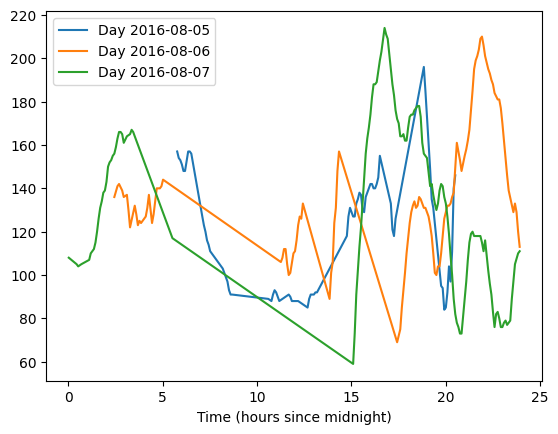

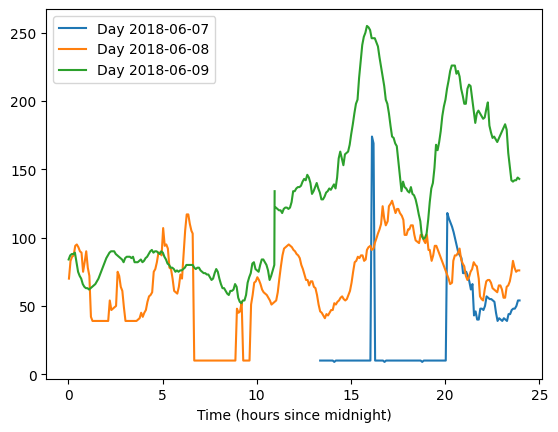

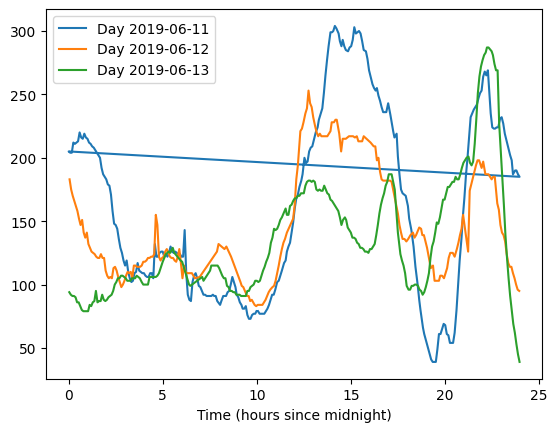

In [15]:
# plot 3 days for each patient in the df
for patient in df.index.unique():
    fig, ax = plt.subplots()
    for day in df.loc[patient]["Day"].unique()[:3]:
        day_data = df.loc[patient].loc[df.loc[patient]["Day"] == day]
        bg = day_data["Glucose"].values  # Blood glucose levels
        datetimes = day_data["DateTime"]  # Datetimes

        # Convert datetimes to hours
        hours = [t.hour + t.minute / 60.0 for t in datetimes]

        # Plot the data
        ax.plot(hours, bg, label=f"Day {day}")

    # Formatting the x-axis to show hours
    ax.set_xlabel('Time (hours since midnight)')

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()



In [16]:
data = df.copy()

In [47]:

class Metrics:
    """A custom class for diabetes-related metrics"""

    def __init__(self, df):
        self.df = df.copy()

    def tar(self, threshold_high=180):
        # Create a new column in the DataFrame that is True where 'Glucose' is above the threshold and False otherwise
        self.df['HighGlucose'] = self.df['Glucose'] >= threshold_high

        # Group by 'Day' and calculate the mean of 'HighGlucose'. This works because True is treated as 1 and False as 0.
        tar_series = self.df.groupby('Day')['HighGlucose'].mean() * 100

        # Convert the resulting Series to a list
        tar_list = tar_series.tolist()

        # Remove the 'HighGlucose' column from the DataFrame
        self.df.drop('HighGlucose', axis=1, inplace=True)

        return tar_list

    def tbr(self, threshold_low=70):
        # Create a new column in the DataFrame that is True where 'Glucose' is below the threshold and False otherwise
        self.df['LowGlucose'] = self.df['Glucose'] <= threshold_low

        # Group by 'Day' and calculate the mean of 'LowGlucose'. This works because True is treated as 1 and False as 0.
        tbr_series = self.df.groupby('Day')['LowGlucose'].mean() * 100

        # Convert the resulting Series to a list
        tbr_list = tbr_series.tolist()

        # Remove the 'LowGlucose' column from the DataFrame
        self.df.drop('LowGlucose', axis=1, inplace=True)

        return tbr_list
    
    
    def tir(self, threshold_low=70, threshold_high=180):
        # Create a new column in the DataFrame that is True where 'Glucose' is between the thresholds and False otherwise
        self.df['InRange'] = np.logical_and(self.df['Glucose'] > threshold_low, self.df['Glucose'] <= threshold_high)

        # Group by 'Day' and calculate the mean of 'InRange'. This works because True is treated as 1 and False as 0.
        tir_series = self.df.groupby('Day')['InRange'].mean() * 100

        # Convert the resulting Series to a list
        tir_list = tir_series.tolist()

        # Remove the 'InRange' column from the DataFrame
        self.df.drop('InRange', axis=1, inplace=True)

        return tir_list

    def gri(self):
        low_list = np.array(self.tir(54, 70))
        vlow_list = np.array(self.tbr(54))
        high_list = np.array(self.tir(180, 250))
        vhigh_list = np.array(self.tar(250))
        gri_list = 3 * (vlow_list) + 2.4 * (low_list) + 1.6 * (vhigh_list) + 0.8 * (high_list)

        return gri_list
    
    def GGE(self):
        """
            Computes and returns the GGE (Greatest Glycemic Excursion)
            Args:
                (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            Returns:
                GGE (float): the GGE, defined as the max - min glucose value of that day
        """

        max_of_day = self.df.groupby('Day')['Glucose'].max()
        min_of_day = self.df.groupby('Day')['Glucose'].min()
        GGE = max_of_day - min_of_day

        return GGE.tolist()
    
    def std(self):
        """
            Computes and returns the standard deviation of glucose values
            Args:
                (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            Returns:
                std (float): the standard deviation of glucose values
        """
        std = self.df.groupby('Day')['Glucose'].std()
        return std
    
    def eA1c(self):
        """
        Computes and returns the American Diabetes Association estimated HbA1c
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            eA1c (float): an estimate of HbA1c from the American Diabetes Association
            
    """
        eA1c = (46.7 + np.mean(self.df['Glucose']))/ 28.7 
        return eA1c
    
    # def MAGE_day(df, std=1):
    #     """
    #         Computes and returns the mean amplitude of glucose excursions
    #         Args:
    #             (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
    #             sd (integer): standard deviation for computing range (default=1)
    #         Returns:
    #             MAGE (float): the mean amplitude of glucose excursions 
    #         Refs:
    #             Sneh Gajiwala: https://github.com/snehG0205/NCSA_genomics/tree/2bfbb87c9c872b1458ef3597d9fb2e56ac13ad64
                
    #     """
    #     #extracting glucose values and incdices
    #     glucose = df['Glucose'].tolist()
    #     ix = [1*i for i in range(len(glucose))]
    #     stdev = std

    #     # local minima & maxima
    #     a = np.diff(np.sign(np.diff(glucose))).nonzero()[0] + 1
    #     # local min
    #     valleys = (np.diff(np.sign(np.diff(glucose))) > 0).nonzero()[0] + 1
    #     # local max
    #     peaks = (np.diff(np.sign(np.diff(glucose))) < 0).nonzero()[0] + 1
    #     # +1 -- diff reduces original index number

    #     #store local minima and maxima -> identify + remove turning points
    #     excursion_points = pd.DataFrame(columns=['Index', 'Time', 'Glucose', 'Type'])
    #     k=0
    #     for i in range(len(peaks)):
    #         excursion_points.loc[k] = [peaks[i]] + [df['Time'][k]] + [df['Glucose'][k]] + ["P"]
    #         k+=1

    #     for i in range(len(valleys)):
    #         excursion_points.loc[k] = [valleys[i]] + [df['Time'][k]] + [df['Glucose'][k]] + ["V"]
    #         k+=1

    #     excursion_points = excursion_points.sort_values(by=['Index'])
    #     excursion_points = excursion_points.reset_index(drop=True)


    #     # selecting turning points
    #     turning_points = pd.DataFrame(columns=['Index', 'Time', 'Glucose', 'Type'])
    #     k=0
    #     for i in range(stdev,len(excursion_points.Index)-stdev):
    #         positions = [i-stdev,i,i+stdev]
    #         for j in range(0,len(positions)-1):
    #             if(excursion_points.Type[positions[j]] == excursion_points.Type[positions[j+1]]):
    #                 if(excursion_points.Type[positions[j]]=='P'):
    #                     if excursion_points.Glucose[positions[j]]>=excursion_points.Glucose[positions[j+1]]:
    #                         turning_points.loc[k] = excursion_points.loc[positions[j+1]]
    #                         k+=1
    #                     else:
    #                         turning_points.loc[k] = excursion_points.loc[positions[j+1]]
    #                         k+=1
    #                 else:
    #                     if excursion_points.Glucose[positions[j]]<=excursion_points.Glucose[positions[j+1]]:
    #                         turning_points.loc[k] = excursion_points.loc[positions[j]]
    #                         k+=1
    #                     else:
    #                         turning_points.loc[k] = excursion_points.loc[positions[j+1]]
    #                         k+=1

    #     if len(turning_points.index)<10:
    #         turning_points = excursion_points.copy()
    #         excursion_count = len(excursion_points.index)
    #     else:
    #         excursion_count = len(excursion_points.index)/2

        
    #     turning_points = turning_points.drop_duplicates(subset= "Index", keep= "first")
    #     turning_points=turning_points.reset_index(drop=True)
    #     excursion_points = excursion_points[excursion_points.Index.isin(turning_points.Index) == False]
    #     excursion_points = excursion_points.reset_index(drop=True)

    #     # calculating MAGE
    #     if excursion_count==0:
    #         mage=0
    #     else:
    #         mage = turning_points.Glucose.sum()/excursion_count

    #     return round(mage,3)
    
    # def MAGE(self):
    #     mage_list = []
    #     for day in self.df.groupby('Day'):
    #         mage_list.append(self.MAGE_day(day[1]))
    #     return mage_list



GRI: [ 1.81818182 13.45132743  8.75        9.96108949  5.82995951 29.84771574
 46.43939394 45.         15.47325103 19.85130112]
GGE: [112, 141, 155, 155, 95, 198, 150, 128, 155, 132]


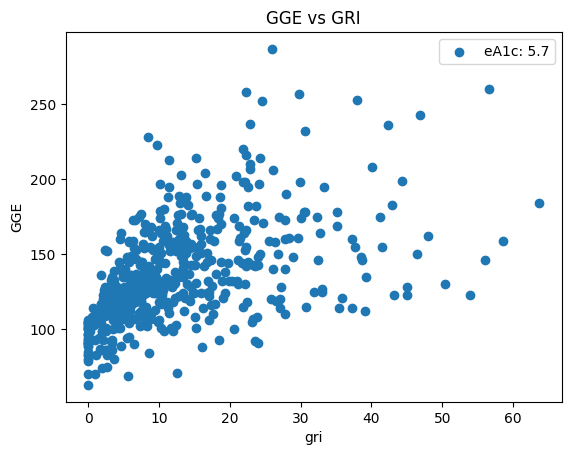

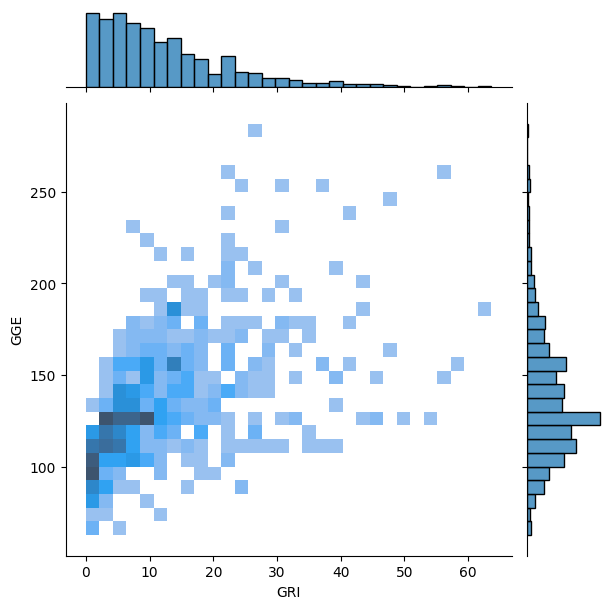

In [59]:
# get the metrics for just one patient
metrics = Metrics(data.loc['72492570'])

#tbr = metrics.tbr()
gri = metrics.gri()
#print(f'TAR: {tar}%')
print(f'GRI: {gri[:10]}')

# get the mage
GGE = metrics.GGE()
print(f'GGE: {GGE[:10]}')
# plot the gri scatter plot
plt.scatter(gri, GGE)
plt.title('GGE vs GRI')
plt.xlabel('gri')
plt.ylabel('GGE')
# add eA1c to legend
eA1c = np.round(metrics.eA1c(),1)
plt.legend([f'eA1c: {eA1c}'])
plt.show()

# a more fancy plot using seaborn jointplot
g = sns.jointplot(x=gri, y=GGE, kind='hist', bins=30, marginal_kws=dict(bins=30))
g.set_axis_labels('GRI', 'GGE')
plt.show()


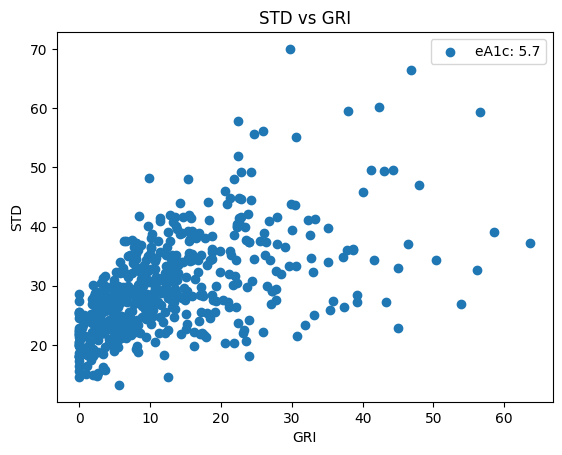

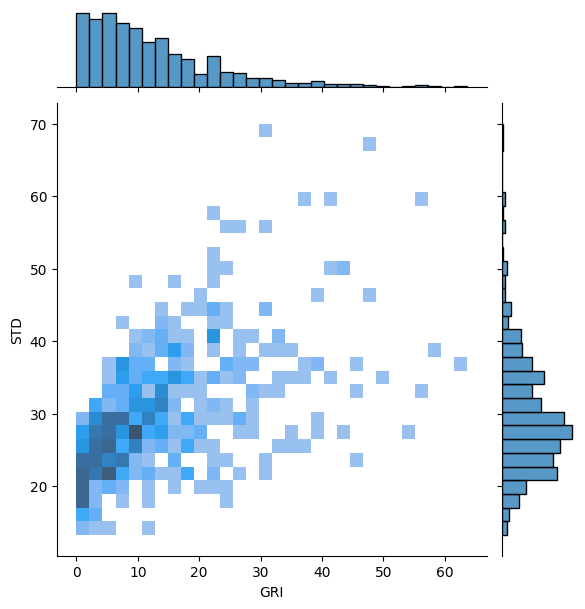

In [60]:
# now plot the GRI vs STD
std = metrics.std()
plt.scatter(gri, std)
plt.title('STD vs GRI')
plt.xlabel('GRI')
plt.ylabel('STD')
# add eA1c to legend
eA1c = np.round(metrics.eA1c(),1)
plt.legend([f'eA1c: {eA1c}'])
plt.show()

# same plot using seaborn jointplot
g = sns.jointplot(x=gri, y=std, kind='hist', bins=30, marginal_kws=dict(bins=30))
g.set_axis_labels('GRI', 'STD')
plt.show()

                                                        GRI  \
72492570  [1.8181818181818183, 13.45132743362832, 8.75, ...   
86323903  [26.666666666666664, 80.0, 85.81818181818181, ...   
64406000  [0.0, 3.529411764705882, 71.65467625899281, 52...   

                                                        GGE  eA1c  
72492570  [112, 141, 155, 155, 95, 198, 150, 128, 155, 1...   5.7  
86323903  [0, 0, 268, 373, 140, 214, 259, 244, 339, 217,...   6.5  
64406000  [5.405459999999991, 96.0, 236.0, 259.0, 258.0,...   6.6  
                GRI    GGE  eA1c
72492570   1.818182    112   5.7
72492570  13.451327    141   5.7
72492570       8.75    155   5.7
72492570   9.961089    155   5.7
72492570    5.82996     95   5.7
...             ...    ...   ...
64406000   6.021505  180.0   6.6
64406000   94.87395  285.0   6.6
64406000   20.84507  191.0   6.6
64406000  55.411255  195.0   6.6
64406000        0.0   64.0   6.6

[2250 rows x 3 columns]


/home/fvaselli/miniconda3/envs/plots/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'density'
  cset = contour_func(


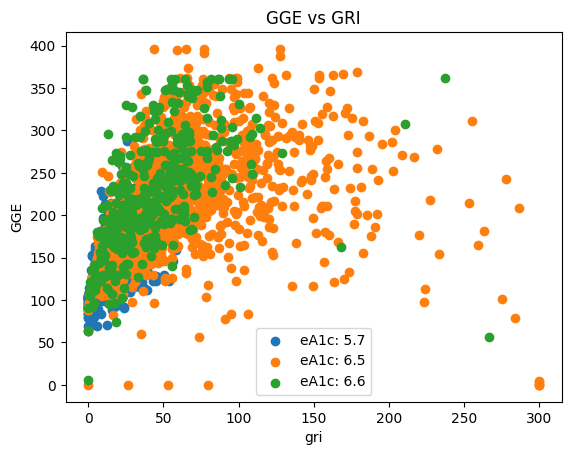

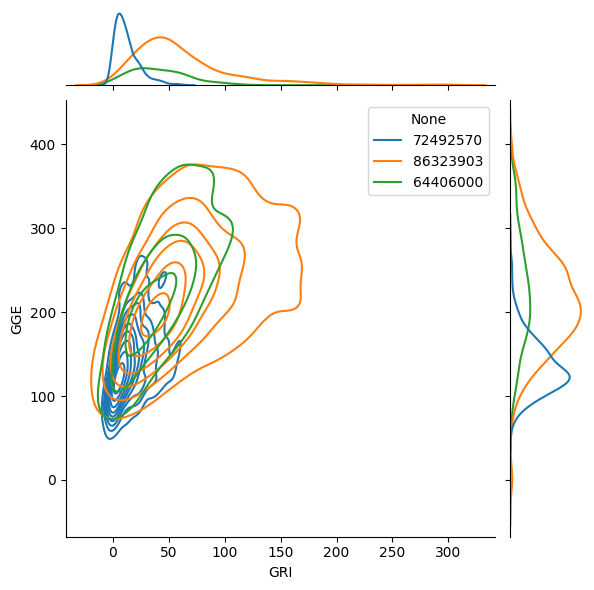

In [39]:
# for each patient, get the gri and plot against the gge
gri_list = []
GGE_list = []
eA1c_list = []
for patient in ds.item():
    metrics = Metrics(data.loc[patient])
    gri = metrics.gri()
    gri_list.append(gri)
    GGE = metrics.GGE()
    GGE_list.append(GGE)
    eA1c = np.round(metrics.eA1c(),1)
    eA1c_list.append(eA1c)

# plot the gri scatter plot
for i, patient in enumerate(ds.item()):
    plt.scatter(gri_list[i], GGE_list[i], label=patient)

# add eA1c to legend
plt.legend([f'eA1c: {eA1c_list[i]}' for i in range(len(eA1c_list))])


plt.title('GGE vs GRI')
plt.xlabel('gri')   
plt.ylabel('GGE')
# plt.show()

# a more fancy plot using seaborn jointplot
# Create a DataFrame with the lists as columns so sns.jointplot() can be used
# patients as index

df = pd.DataFrame({'GRI': gri_list, 'GGE': GGE_list, 'eA1c': eA1c_list}, index=ds.item().keys())
print(df)
df = df.explode(['GRI', 'GGE'])
print(df)

g = sns.jointplot(x='GRI', y='GGE', data=df, kind='kde', hue=df.index, density=True)    
g.set_axis_labels('GRI', 'GGE')
# put eA1c in legend

plt.show()



In [ ]:
# some days are missing data
# fill in missing data with the mean of the current day

time_stamps = np.arange(0, 24 * 3600, 60 * 5)
print((time_stamps))
def fill_missing_data(day_data):
    bg = [t[0] for t in day_data]  # Blood glucose levels
    mean = np.mean(bg)
    seconds = np.array([t[1] for t in day_data])  # Seconds of the day
    print(seconds)

    # Convert seconds to hours
    # hours = np.array(seconds) / 3600.0

    # just use the mean for missing data
    zeros = np.zeros_like(time_stamps)
    # find the indices to fill
    indices = np.searchsorted(time_stamps, seconds, side='left') -1
    indices[indices == 288] = 287
    # fill the data
    zeros[indices] = bg
    # fill in the missing data with the mean
    zeros[zeros == 0] = mean


    # Return the interpolated data
    return zeros

# test it on day 0
day_data = ds.item().get("72492570")[2]
interpolated_bg = fill_missing_data(day_data)

# Plot the original and interpolated data
plt.scatter(time_stamps / 3600.0, interpolated_bg, label='interpolated')
plt.scatter([t[1] / 3600.0 for t in day_data], [t[0] for t in day_data], label='original')
plt.show()
